# 1.) Import an asset price from Yahoo Finance

In [51]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("TSLA", start="2010-07-01", end="2022-02-21")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day Build an RNN Architecture accordingly

In [52]:
x_train = []
y_train = []

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 6
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i - input_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(
    LSTM(units=x_train.shape[1],
         return_sequences=True,
         input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
2338/2338 [==============================] - 8s 3ms/step - loss: 0.0011
Epoch 2/3
2338/2338 [==============================] - 6s 3ms/step - loss: 0.0010
Epoch 3/3
2338/2338 [==============================] - 6s 3ms/step - loss: 0.0010


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [53]:
test_data = scaled_data[training_data_len - input_size:, :]

# Make predictions on the test data
window_size = 6
x_test, y_test = [], []

for i in range(window_size, len(test_data)):
    x_test.append(test_data[i - window_size:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

In [55]:
from sklearn.metrics import mean_squared_error

in_sample_mse = mean_squared_error(y_train, model.predict(x_train))
in_sample_rw_mse = mean_squared_error(y_train[1:], y_train[:-1])
out_sample_mse = mean_squared_error(y_test, model.predict(x_test))
out_sample_rw_mse = mean_squared_error(y_test[1:], y_test[:-1])

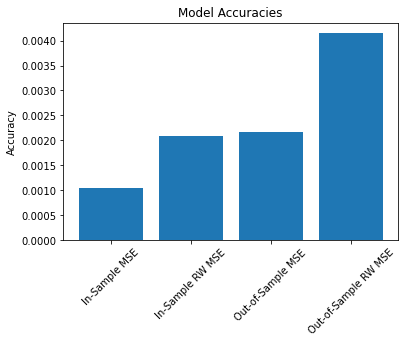

In [57]:
import matplotlib.pyplot as plt

labels = ['In-Sample MSE', 'In-Sample RW MSE', 'Out-of-Sample MSE', 'Out-of-Sample RW MSE']
values = [in_sample_mse, in_sample_rw_mse, out_sample_mse, out_sample_rw_mse]

plt.bar(labels, values)
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.xticks(rotation=45)
plt.show()

# 4.) Plot in and out of sample accuracy

# 5.) Write an observation/conclusion about the graphs from Q4 and Q3

In-sample MSE is much lower that In-sample RW MSE and Out-of-Sample MSE, which means our model is better than RW. And works better on in-sample data than out-of-sample data. Also Out-of-Sample MSE is much lower than Out-of-Sample RW MSE, which also proves our model make sence.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast